In [3]:
import pandas as pd
import numpy as np
from core import Backtest, PlotPoint, IStrategy
from binance.enums import HistoricalKlinesType
from binance import Client
from multiprocessing import Pool
from math import log
from datetime import datetime
import optuna
import talib

In [4]:
class MA(IStrategy):
    def __init__(self, symbol1, symbol2, ma_span, kill, offset, ex, z_treshold, z_span, quantity=0.002):
        self.ma = []
        self.diff = []
        self.data1 = []
        self.quantity = quantity
        self.data2 = []
        self.ex = ex
        self.upper = []
        self.middle = []
        self.lower = []
        self.ma_span = ma_span
        self.ema_alpha = 0
        self.scale = -1
        self.position = 0
        self.enter_price = None
        self.symbol1 = symbol1
        self.symbol2 = symbol2
        self.offset = offset
        self.trades = []
        self.z_span = z_span
        self.z_treshold = z_treshold
        self.up_or_down = 0
        self.lets_wait_after_buy = 0
        self.lets_wait_after_sell = 0
        self.kill = kill
        self.zscore = []

    def _update_bbands(self, feeds):
        close1 = feeds[self.symbol1].close[-self.ma_span:]
        close2 = feeds[self.symbol2].close[-self.ma_span:]
        upper, middle, lower = talib.BBANDS(np.array(close1) - np.array(close2) * self.scale, timeperiod=self.ma_span)
        self.upper.append(upper[-1])
        self.middle.append(middle[-1])
        self.lower.append(lower[-1])

    def _update_zscore(self, feeds):
        close1 = feeds[self.symbol1].close[-self.z_span:]
        close2 = feeds[self.symbol2].close[-self.z_span:]
        prices = pd.DataFrame(data={'Close_x': close1, 'Close_y' : close2})
        # res = sm.ols(formula="Close_x~Close_y", data=prices).fit()
        # b = res.params.Close_y
        b = sum(close1) / (sum(close2) * self.scale)
        spread = prices.Close_x- prices.Close_y*b
        zs = (spread - np.mean(spread))/np.std(spread)
        self.zscore.append(zs.iloc[-1])

    def make_decision(self, feeds):
        if self.scale <= 0:
            self.scale = feeds[self.symbol1].close[0]/feeds[self.symbol2].close[0]
        self.ma = self.middle
        self._update_bbands(feeds)
        self.diff.append(feeds[self.symbol1].close[-1] - feeds[self.symbol2].close[-1] * self.scale)

        if len(self.diff) < max(self.ma_span, self.ex):
            return dict()

        self._update_zscore(feeds)
        if (self.position == 1) & (np.array(self.diff[-self.ex::]).mean() < self.ma[-1]) & (self.diff[-1] > self.ma[-1]):
            self.up_or_down = 1
        elif (self.position == -1) & (np.array(self.diff[-self.ex::]).mean() > self.ma[-1]) & (self.diff[-1] < self.ma[-1]):
            self.up_or_down = -1
        else:
            self.up_or_down = 0
        if self.lets_wait_after_buy == 1:
            if self.ma[-1] <= self.diff[-1]:
                self.lets_wait_after_buy = 0
            else:
                return dict()
        elif self.lets_wait_after_sell == 1:
            if self.ma[-1] >= self.diff[-1]:
                self.lets_wait_after_sell = 0
            else:
                return dict()

        if (self.lets_wait_after_buy == 1) | (self.lets_wait_after_sell == 1):
            return dict()


        if self.position == 1:
            if (self.diff[-1] - self.enter_price > self.kill*(self.upper[-1] - self.middle[-1])) | \
                    ((self.ma[-1] - self.diff[-1]) > self.offset*(self.middle[-1] - self.lower[-1])) | (self.up_or_down == 1)  | ((abs(self.zscore[-1]))  <= (self.z_treshold/2)):
                self.position = 0
                self.trades.append(PlotPoint(
                    tick=len(self.diff) - 1,
                    name='exit_sell',
                    value=self.diff[-1]
                ))
                if (self.diff[-1] - self.enter_price > self.kill*(self.upper[-1] - self.middle[-1])) | (self.up_or_down == 1):
                    self.lets_wait_after_sell = 1

                return dict()
            else:
                return {self.symbol1: -self.quantity, self.symbol2: self.quantity}

        elif self.position == -1:
            if (self.enter_price - self.diff[-1] > self.kill*(self.middle[-1] - self.lower[-1])) | \
                    ((self.diff[-1] - self.ma[-1]) > self.offset*(self.upper[-1] - self.middle[-1])) | (self.up_or_down == -1) | ((abs(self.zscore[-1]))  <= (self.z_treshold/2)):
                self.position = 0
                self.trades.append(PlotPoint(
                    tick=len(self.diff) - 1,
                    name='exit_buy',
                    value=self.diff[-1]
                ))
                if (self.enter_price - self.diff[-1] > self.kill*(self.middle[-1] - self.lower[-1])) | (self.up_or_down == -1):
                    self.lets_wait_after_buy = 1

                return dict()
            else:
                return {self.symbol1: self.quantity, self.symbol2: -self.quantity}
        else:
            if self.diff[-1] - self.ma[-1] > self.offset*(self.upper[-1] - self.middle[-1]) and \
                    self.zscore[-1] >= self.z_treshold:
                self.position = 1
                self.enter_price = self.diff[-1]
                self.trades.append(PlotPoint(
                    tick=len(self.diff) - 1,
                    name='enter_sell',
                    value=self.diff[-1]
                ))
                return {self.symbol1: -self.quantity, self.symbol2: self.quantity}
            elif self.ma[-1] - self.diff[-1] > self.offset*(self.middle[-1] - self.lower[-1]) and \
                    self.zscore[-1] <= -self.z_treshold:
                self.position = -1
                self.enter_price = self.diff[-1]
                self.trades.append(PlotPoint(
                    tick=len(self.diff) - 1,
                    name='enter_buy',
                    value=self.diff[-1]
                ))
                return {self.symbol1: self.quantity, self.symbol2: -self.quantity}
            else:
                return dict()

    def get_plot_lines(self):
        return [{'{} - {}'.format(self.symbol1, self.symbol2): self.diff,
                 'MA span={}'.format(self.ma_span): self.ma,
                 'Upper bound= {}'.format(self.ma_span): self.upper,
                 'Lower bound= {}'.format(self.ma_span): self.lower}]

    def get_plot_points(self):
        return [self.trades]

    def get_name(self):
        return 'MA {}, {}'.format(self.symbol1, self.symbol2)

In [5]:
apiKey='123'
apiSec='321'

columns = [
    "Open time", "Open", "High", "Low", "Close", "Volume", "Close time",
    "Quote asset volume", "Number of trades", "Taker buy base asset volume",
    "Taker buy quote asset volume", "Ignore"
]

client=Client(apiKey,apiSec)
candles_eth = client.get_historical_klines('ETHUSDT', Client.KLINE_INTERVAL_1MINUTE, "7 day ago UTC", klines_type=HistoricalKlinesType.FUTURES)

train_e = pd.DataFrame(candles_eth).set_index(0)
train_e.index = [datetime.utcfromtimestamp(train_e.index[i]/1000).strftime('%Y-%m-%d %H:%M:%S') for i in range(train_e.shape[0])]
train_e.columns = columns[1:12]
train_e.Close = train_e.Close.apply(lambda x: float(x))
train_e.Volume = train_e.Volume.apply(lambda x: float(x))

In [6]:
for coin in ['COMPUSDT']:
    candles_n = client.get_historical_klines(coin, Client.KLINE_INTERVAL_1MINUTE,  "7 day ago UTC", klines_type=HistoricalKlinesType.FUTURES)

    train_n = pd.DataFrame(candles_n).set_index(0)
    train_n.index = [datetime.utcfromtimestamp(train_n.index[i]/1000).strftime('%Y-%m-%d %H:%M:%S') for i in range(train_n.shape[0])]
    train_n.columns = columns[1:12]
    train_n.Close = train_n.Close.apply(lambda x: float(x))
    train_n.Volume = train_n.Volume.apply(lambda x: float(x))


    train = pd.merge(train_n, train_e, left_index=True, right_index=True)

100%|██████████| 10080/10080 [00:06<00:00, 1525.35it/s]


{'total_profit': -0.2733425280000004, 'num_trades': 35, 'sortino_ratio': -0.006919741363054412, 'return, %': -8.018543568562121}


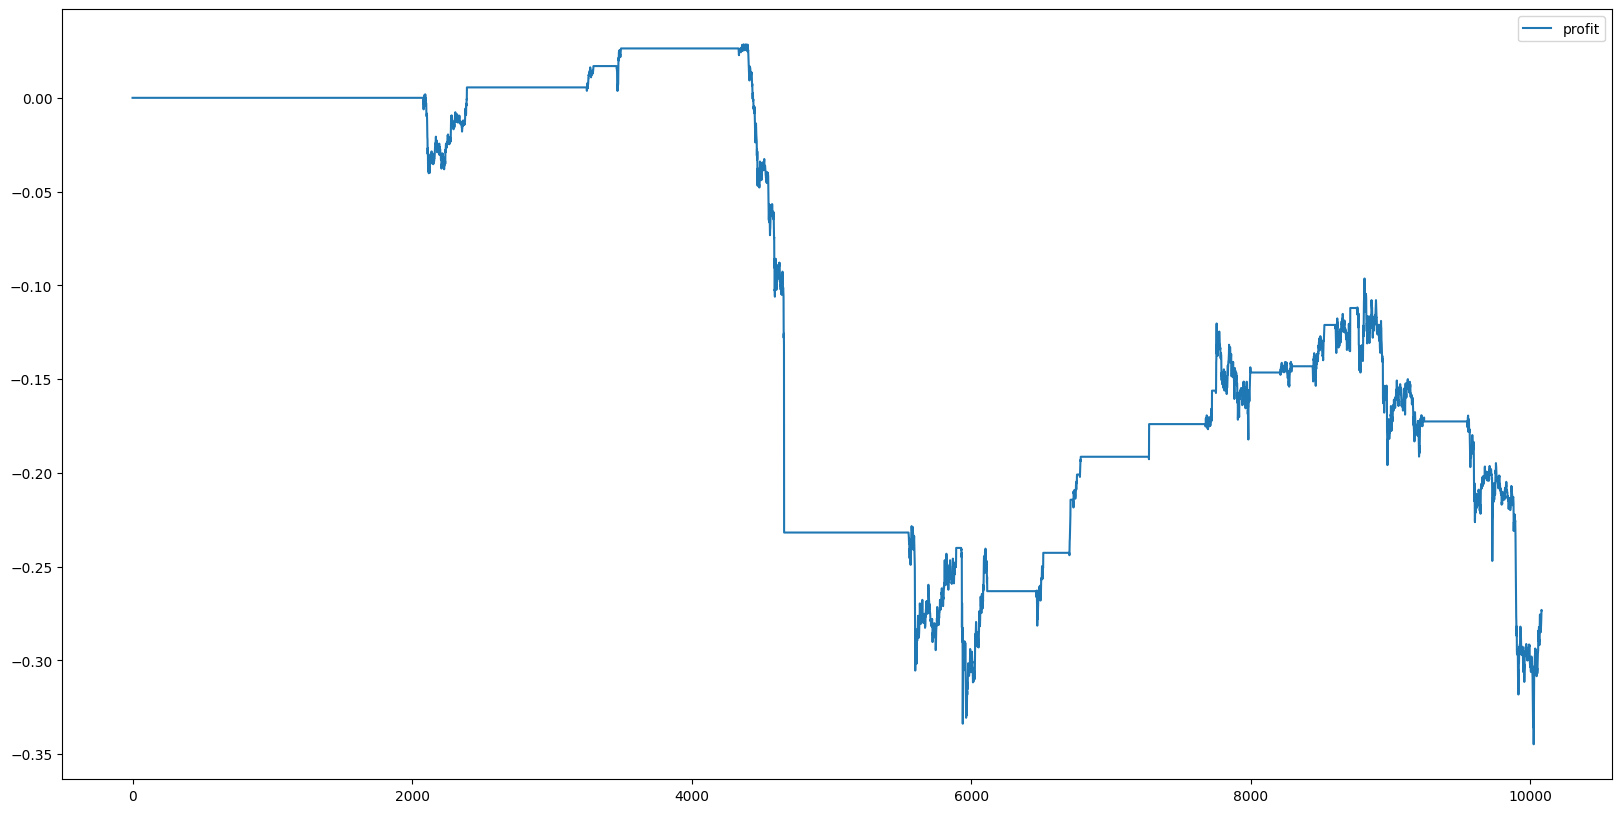

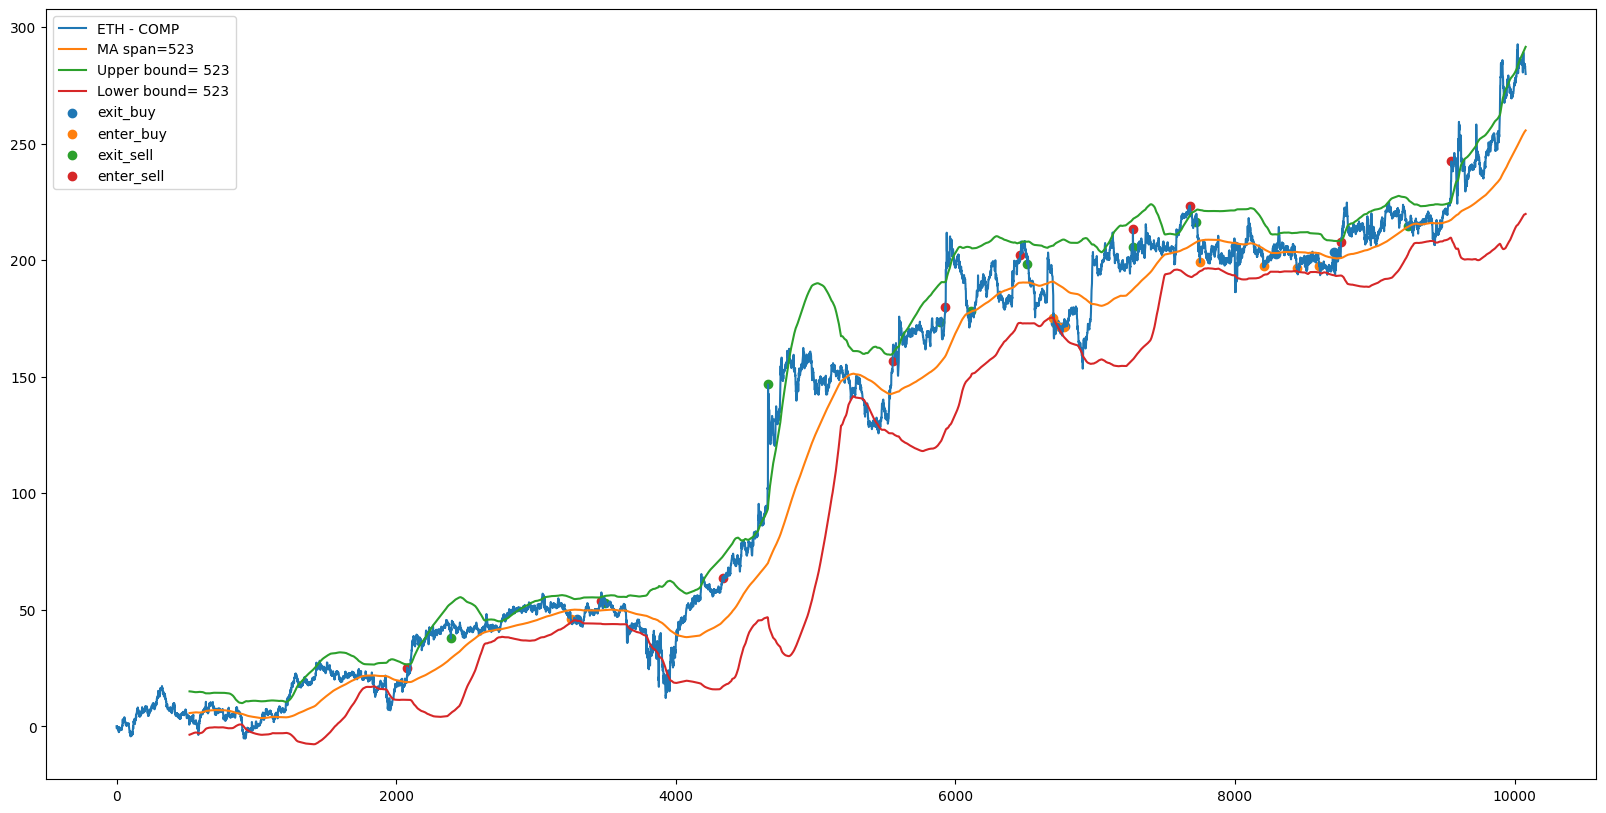

In [7]:
feeds = {
    'ETH': pd.DataFrame({'Close':train.Close_y}), 'COMP' : pd.DataFrame({'Close':train.Close_x})
}

param = {
    'ma_span': 523,
    'kill': 1.849365539590282,
    'offset': 0.6622826410696923,
    'ex': 5,
    'z_treshold': 1.2880626884903394,
    'z_span': 824,
    'symbol1': 'ETH',
    'symbol2': 'COMP',
    'quantity': 0.002
}

strategy = MA(**param)
bt = Backtest(feeds, strategy) # commision=0,0004
res, trades = bt.run(plot=True)
print(res)

In [8]:
train

,Open_x,High_x,Low_x,Close_x,Volume_x,Close time_x,Quote asset volume_x,Number of trades_x,Taker buy base asset volume_x,Taker buy quote asset volume_x,...,High_y,Low_y,Close_y,Volume_y,Close time_y,Quote asset volume_y,Number of trades_y,Taker buy base asset volume_y,Taker buy quote asset volume_y,Ignore_y
2022-10-22 11:20:00,50.30,50.35,50.29,50.30,385.829,1666437659999,19414.49550,85,238.666,12010.27209,...,1304.97,1304.19,1304.44,1851.542,1666437659999,2415546.50631,1216,975.774,1272951.59189,0
2022-10-22 11:21:00,50.31,50.32,50.30,50.32,48.854,1666437719999,2457.88639,22,40.788,2052.10264,...,1304.52,1304.17,1304.19,1308.194,1666437719999,1706368.98910,778,485.411,633155.90705,0
2022-10-22 11:22:00,50.31,50.33,50.30,50.33,26.531,1666437779999,1335.13636,19,26.048,1310.84041,...,1304.29,1304.19,1304.28,423.925,1666437779999,552916.37162,356,139.738,182258.31506,0
2022-10-22 11:23:00,50.32,50.32,50.30,50.30,44.792,1666437839999,2253.09538,16,2.079,104.57370,...,1304.29,1303.68,1303.82,1966.558,1666437839999,2564343.91692,955,773.902,1009113.24620,0
2022-10-22 11:24:00,50.31,50.31,50.28,50.28,109.093,1666437899999,5487.24957,30,62.082,3122.91617,...,1303.90,1303.55,1303.56,1376.967,1666437899999,1795192.50925,723,851.147,1109667.33524,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-29 11:15:00,51.58,51.64,51.52,51.54,321.624,1667042159999,16591.92462,116,140.021,7225.44869,...,1620.79,1618.65,1619.90,4025.272,1667042159999,6520841.97108,3060,1487.699,2410028.36569,0
2022-10-29 11:16:00,51.54,51.57,51.50,51.54,118.969,1667042219999,6131.03987,61,49.638,2558.05574,...,1619.90,1616.82,1618.35,14622.606,1667042219999,23656825.34959,5375,6120.567,9900499.34530,0
2022-10-29 11:17:00,51.53,51.54,51.47,51.51,245.053,1667042279999,12621.66850,67,46.195,2379.71985,...,1618.35,1615.15,1617.05,9824.272,1667042279999,15884067.04052,4812,4108.832,6642775.19201,0
2022-10-29 11:18:00,51.49,51.50,51.47,51.48,137.484,1667042339999,7079.42491,31,120.914,6226.47926,...,1617.10,1615.10,1615.25,4913.675,1667042339999,7940218.58955,3197,1943.310,3140068.56671,0


# Train-Train

In [9]:
train = train.iloc[0:100]

In [10]:
def objective(trial):
    param = {
        'symbol1' : 'ETH',
        'symbol2' : 'COMP',        
        'ma_span' :  trial.suggest_int('ma_span', 500, 1500),
        'kill' : trial.suggest_float('kill', 1, 2),
        'offset' : trial.suggest_float('offset', 0.6, 1.2),   
        'ex' : trial.suggest_int('ex', 2, 5),
        'z_treshold' : trial.suggest_float('z_treshold', 1.25, 2.5),
        'z_span' : trial.suggest_int('z_span', 500, 1500),
        'quantity' : 0.002
    }

    strategy = MA(**param)
    bt = Backtest(feeds, strategy)
    res, mas = bt.run(plot=False)
    s_r = res['sortino_ratio']
    if np.isnan(s_r):
        s_r = 0
    return s_r

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

res_params = study.best_params
res_params['symbol1'] = 'ETH'
res_params['symbol2'] = 'COMP'
res_params['quantity'] = 0.002

[I 2022-10-29 21:19:45,497] A new study created in memory with name: no-name-1c0833ee-3ad4-4be1-bf08-d61653dca170
100%|██████████| 10080/10080 [00:05<00:00, 1707.99it/s]
[I 2022-10-29 21:19:51,419] Trial 0 finished with value: -0.004705412807818578 and parameters: {'ma_span': 1482, 'kill': 1.524205583315222, 'offset': 0.799792591567583, 'ex': 4, 'z_treshold': 1.77633489218246, 'z_span': 531}. Best is trial 0 with value: -0.004705412807818578.
100%|██████████| 10080/10080 [00:08<00:00, 1253.87it/s]
[I 2022-10-29 21:19:59,479] Trial 1 finished with value: -0.0021565144790028326 and parameters: {'ma_span': 884, 'kill': 1.159132780239204, 'offset': 1.1286576272135636, 'ex': 3, 'z_treshold': 1.7008230289956963, 'z_span': 1377}. Best is trial 1 with value: -0.0021565144790028326.
100%|██████████| 10080/10080 [00:07<00:00, 1401.48it/s]
[I 2022-10-29 21:20:06,691] Trial 2 finished with value: -0.005356705177389495 and parameters: {'ma_span': 888, 'kill': 1.2879035503707879, 'offset': 0.8730815

In [11]:
res_params

{'ma_span': 809,
 'kill': 1.4853942580543604,
 'offset': 1.1905134504701973,
 'ex': 4,
 'z_treshold': 2.312639481942385,
 'z_span': 1109,
 'symbol1': 'ETH',
 'symbol2': 'COMP',
 'quantity': 0.002}

# Train-Test

In [13]:
def objective(trial):
    param = {
        'symbol1' : 'ETH',
        'symbol2' : 'COMP',        
        'ma_span' :  trial.suggest_int('ma_span', 500, 1500),
        'kill' : trial.suggest_float('kill', 1, 2),
        'offset' : trial.suggest_float('offset', 0.6, 1.2),   
        'ex' : trial.suggest_int('ex', 2, 5),
        'z_treshold' : trial.suggest_float('z_treshold', 1.25, 2.5),
        'z_span' : trial.suggest_int('z_span', 500, 1500),
        'quantity' : 0.002
    }
    strategy = Jma(**param)
    bt = Backtest(feeds, strategy)
    res, mas = bt.run(plot=False)
    s_r = res['sortino_ratio']
    if np.isnan(s_r):
        s_r = 0
    return s_r


window = 60*24*7
backtest_result = {}
print(datetime.now())


def period_return(args, position):
    feeds = {
    'ETH': train.iloc[position-1300:position+window]
    }
    
    strategy = Jma(**args)
    bt = Backtest(feeds, strategy)
    res, trades = bt.run(plot=False)
    return res['total_profit']

def f(args):
    strategy = Jma(*args)
    bt = Backtest(feeds, strategy)
    return bt.run(plot=False)


for step in range(0, train.shape[0]-3*window, window):
    print(datetime.now())    
    backtest = {}
    feeds = {
        'ETH': train.iloc[step:step+2*window]
    }
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=75)

    res_params = study.best_params
    res_params['symbol1'] = 'ETH'
    res_params['quantity'] = 0.002


    backtest['total_profit'] = period_return(res_params, step+1*window)
    backtest.update(res_params)
    
    backtest_result[train.iloc[step+2*window].name] = backtest

2022-10-30 18:59:53.392345
